### Resting State EEG: aperiodic 1/f-like activity + band power analysis
Spectral analysis using Welch's PSD estimation, fitting the spectra to model to estimate aperiodic compoenent of the spectra (i.e. exponent and offset). After that, flatten the spectra (i.e. substact aperiodic component from the spectra) to calculate alpha power peak and center frequency and alpha band power (relative and absolute).

In [9]:
# Import packages
import os, mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fooof import FOOOF
from fooof.plts.spectra import plot_spectrum

# Set default directory
os.chdir('/Users/tanijarv/Documents/GitHub/EEG-pyline')

# Import functions
from signal_processing.spectral_analysis import calculate_psd, find_ind_band
import basic.arrange_data as arrange

Define these variables!

In [10]:
# Folder where to get the clean epochs files
clean_folder = 'Data/Clean/'

# Folder where to save the results
results_foldername = 'Results/'

# Sub-folder for the experiment (i.e. timepoint or group) and its acronym
exp_folder = 'test_experiment'
exp_condition = 'EC_test'

# Brain regions and their channels
brain_regions = {'Frontal' : ['Fp1', 'Fp2', 'AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'Fz',
                              'FC5', 'FC6', 'FC1', 'FC2'],
                 'Parietal' : ['C3', 'C4', 'Cz', 'CP5', 'CP6', 'CP1', 'CP2', 'P3', 'P4',
                               'Pz', 'PO3', 'PO4']}

# Power spectra estimation parameters
psd_params = dict(method='welch', fminmax=[1, 30], window='hamming', window_duration=2.5,
                  window_overlap=0.5, zero_padding=39)

# FOOOF (specparam) model parameters
fooof_params = dict(peak_width_limits=[1,12], max_n_peaks=float('inf'), min_peak_height=0.225,
                    peak_threshold=2.0, aperiodic_mode='fixed')

# Band power of interest
bands = {'Alpha' : [7, 14]}

# Flattened spectra amplitude scale (linear, log)
flat_spectr_scale = 'log'

# Plot more information on the model fit plots or not; and save these plots or not
plot_rich = True
savefig = False

Run this to set the folders for data.

In [11]:
# Get directories of clean EEG files and set export directory
dir_inprogress = os.path.join(clean_folder, exp_folder)
file_dirs, subject_names = arrange.read_files(dir_inprogress, "_clean-epo.fif")

Files in Data/Clean/test_experiment read in: 1


Run this to analyse the EEG signal in the frequency domain (i.e. do spectral analysis) using Welch's PSD method and fitting the spectra to FOOOF (specparam) model to estimate aperiodic component of the signal, export this and also remove the aperiodic component to flatten the spectrum and calculate alpha peak parameters and powers.

---
PSD (welch) calculation

<Power Spectrum (from Epochs, welch method) | 42 epochs × 32 channels × 2901 freqs, 1.0-30.0 Hz>
Window type: hamming
Window size: 2560
Overlap: 1280
Zero-padding: 99840

Samples per segment: 2560
Samples for FFT: 102400
Frequency resolution: 0.010000000000000009 Hz


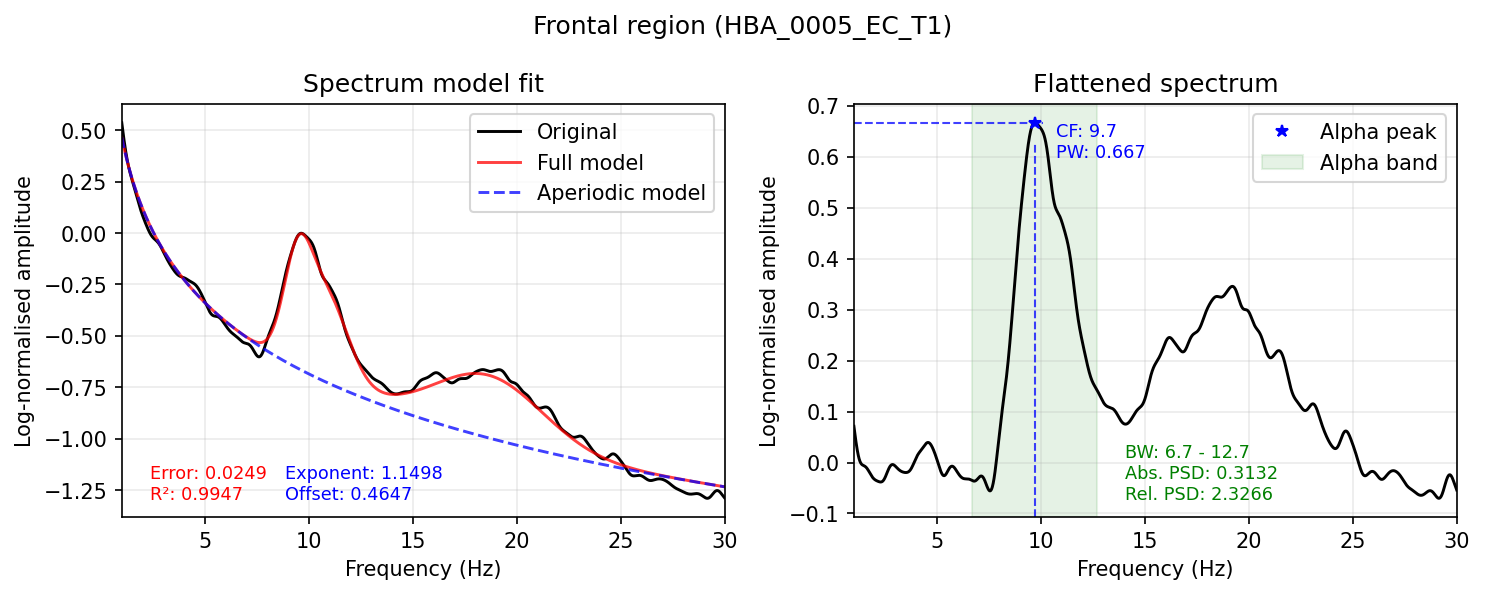

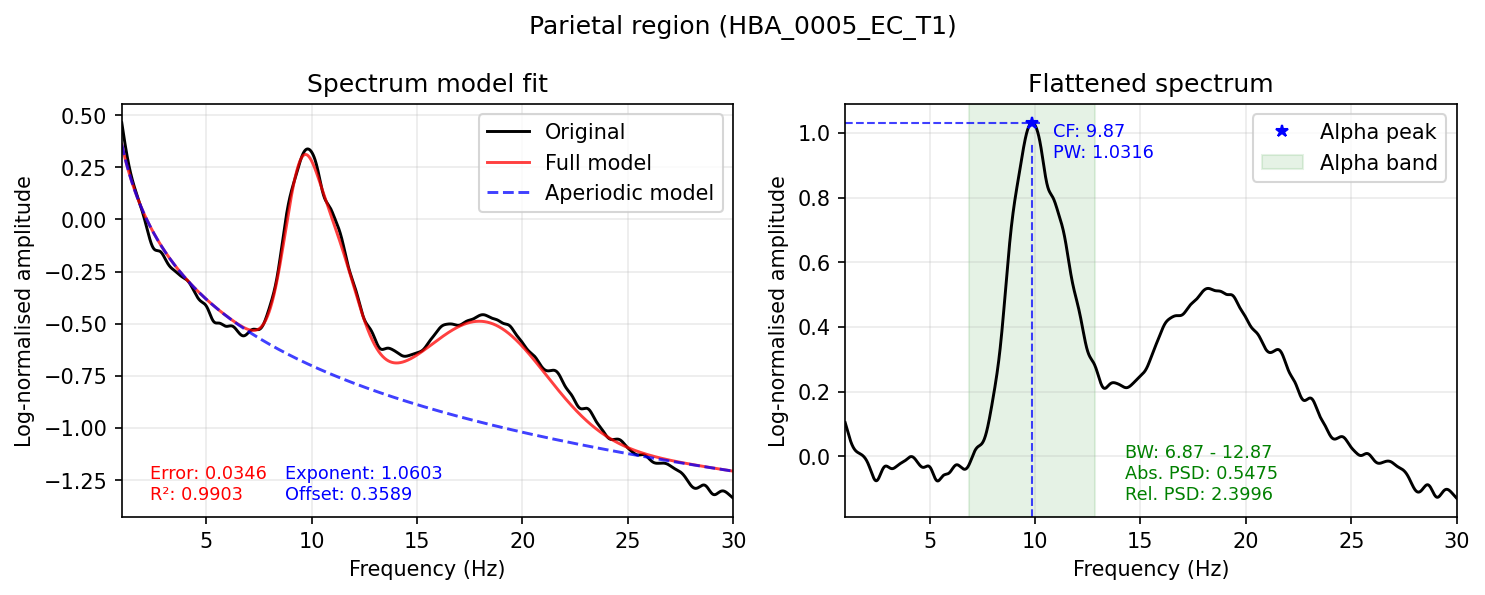

,Exponent,Offset,Alpha CF,Alpha PW,Alpha BW,Alpha absolute power,Alpha relative power,R_2,Error
HBA_0005_EC_T1,1.149766,0.464744,9.7,0.667032,"[6.7, 12.7]",0.313194,2.326607,0.994688,0.024925


,Exponent,Offset,Alpha CF,Alpha PW,Alpha BW,Alpha absolute power,Alpha relative power,R_2,Error
HBA_0005_EC_T1,1.06027,0.358914,9.87,1.031587,"[6.87, 12.87]",0.547471,2.399635,0.990307,0.03464


In [12]:
# Pre-create results folders for spectral analysis data
arrange.create_results_folders(exp_folder=exp_folder, results_folder=results_foldername, fooof=True)

# Go through all the files (subjects) in the folder
for i in range(len(file_dirs)):
    # Read the clean data from the disk
    epochs = mne.read_epochs(fname='{}/{}_clean-epo.fif'.format(dir_inprogress, subject_names[i]),
                                                                verbose=False)

    # Calculate Welch's power spectrum density (FFT) -> (epochs, channels, freq bins) shape
    [psds, freqs] = calculate_psd(epochs, subject_names[i], **psd_params, verbose=True, plot=False)
    
    # Average all epochs and channels together -> (freq bins,) shape
    if i == 0:
        psds_allch = np.zeros(shape=(len(file_dirs), len(freqs)))
    psds_allch[i] = psds.mean(axis=(0, 1))

    # Average all epochs together for each channel and also for each region
    psds = psds.mean(axis=(0))
    df_psds_ch = arrange.array_to_df(subject_names[i], epochs, psds).\
                         reset_index().drop(columns='Subject')
    df_psds_regions = arrange.df_channels_to_regions(df_psds_ch, brain_regions).\
                              reset_index().drop(columns='Subject')

    # Loop through all regions of interest
    for region in df_psds_regions.columns:
        if i == 0:
            globals()["df_fooof_"+region] = pd.DataFrame(index=subject_names)
        max_n_peaks = float("inf")
        psds_temp = df_psds_regions[region].to_numpy()

        # Fit the spectrum with FOOOF        
        fm = FOOOF(**fooof_params, verbose=True)
        fm.fit(freqs, psds_temp, psd_params['fminmax'])
            
        # Log-linear conversion based on the chosen amplitude scale
        if flat_spectr_scale == 'linear':
            flatten_spectrum = 10 ** fm._spectrum_flat
            flat_spectr_ylabel = 'Amplitude (uV\u00b2/Hz)'
        elif flat_spectr_scale == 'log':
            flatten_spectrum = fm._spectrum_flat
            flat_spectr_ylabel = 'Log-normalised amplitude'

        # Find individual alpha band parameters
        cf, pw, bw, abs_bp, rel_bp = find_ind_band(flatten_spectrum, freqs,
                                                   bands['Alpha'], bw_size=6)

        # Set plot styles
        data_kwargs = {'color' : 'black', 'linewidth' : 1.4,
                       'label' : 'Original'}
        model_kwargs = {'color' : 'red', 'linewidth' : 1.4, 'alpha' : 0.75,
                        'label' : 'Full model'}
        aperiodic_kwargs = {'color' : 'blue', 'linewidth' : 1.4, 'alpha' : 0.75,
                            'linestyle' : 'dashed', 'label' : 'Aperiodic model'}
        flat_kwargs = {'color' : 'black', 'linewidth' : 1.4}
        hvline_kwargs = {'color' : 'blue', 'linewidth' : 1.0, 'linestyle' : 'dashed', 'alpha' : 0.75}

        # Plot power spectrum model + aperiodic fit
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=150)
        plot_spectrum(fm.freqs, fm.power_spectrum,
                      ax=axs[0], plot_style=None, **data_kwargs)
        plot_spectrum(fm.freqs, fm.fooofed_spectrum_,
                      ax=axs[0], plot_style=None, **model_kwargs)
        plot_spectrum(fm.freqs, fm._ap_fit,
                      ax=axs[0], plot_style=None, **aperiodic_kwargs)
        axs[0].set_xlim(psd_params['fminmax'])
        axs[0].grid(linewidth=0.2)
        axs[0].set_xlabel('Frequency (Hz)')
        axs[0].set_ylabel('Log-normalised amplitude')
        axs[0].set_title('Spectrum model fit')
        axs[0].legend()
        
        # Flattened spectrum plot (i.e., minus aperiodic fit)
        plot_spectrum(fm.freqs, flatten_spectrum,
                      ax=axs[1], plot_style=None, **flat_kwargs)
        axs[1].plot(cf, pw, '*', color='blue', label='{} peak'.format(list(bands.keys())[0]))
        axs[1].set_xlim(psd_params['fminmax'])
        axs[1].axvline(x=cf, ymin=0, ymax=pw/(pw*1.1), **hvline_kwargs)
        axs[1].axhline(y=pw, xmin=0, xmax=cf/(psd_params['fminmax'][1]+1), **hvline_kwargs)
        axs[1].axvspan(bw[0], bw[1], alpha=0.1, color='green', label='{} band'.format(list(bands.keys())[0]))
        axs[1].grid(linewidth=0.2)
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel(flat_spectr_ylabel)
        axs[1].set_title('Flattened spectrum')
        axs[1].legend()

        # If true, plot all the exported variables on the plots
        if plot_rich == True:
            axs[0].annotate('Error: ' + str(np.round(fm.get_params('error'), 4)) +
                        '\nR\u00b2: ' + str(np.round(fm.get_params('r_squared'), 4)),
                        (0.1, 0.16), xycoords='figure fraction', color='red', fontsize=8.5)
            axs[0].annotate('Exponent: ' + str(np.round(fm.get_params('aperiodic_params','exponent'), 4)) +
                        '\nOffset: ' + str(np.round(fm.get_params('aperiodic_params','offset'), 4)),
                        (0.19, 0.16), xycoords='figure fraction', color='blue', fontsize=8.5)
            axs[1].text(cf+1, pw, 'CF: '+str(np.round(cf, 4))+'\nPW: '+str(np.round(pw, 4)),
                        verticalalignment='top', color='blue', fontsize=8.5)
            axs[1].annotate('BW: '+str(np.round(bw[0], 4))+' - '+str(np.round(bw[1], 4))+
                            '\nAbs. PSD: '+str(np.round(abs_bp, 4))+'\nRel. PSD: '+str(np.round(rel_bp, 4)),
                            (0.75, 0.16), xycoords='figure fraction', color='green', fontsize=8.5)
        
        plt.suptitle('{} region ({})'.format(region, subject_names[i]))
        plt.tight_layout()
        if savefig == True:
            plt.savefig(fname='{}/FOOOF/{}/{}_{}_{}_fooof.png'.format(results_foldername, exp_folder,
                                                                      exp_condition, subject_names[i],
                                                                      region), dpi=300)
        plt.show()

        # Add model parameters to dataframe
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'Exponent']\
                                                        = fm.get_params('aperiodic_params','exponent')
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'Offset']\
                                                        = fm.get_params('aperiodic_params','offset')
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} CF'.\
                        format(list(bands.keys())[0])] = cf
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} PW'.\
                        format(list(bands.keys())[0])] = pw
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} BW'.\
                        format(list(bands.keys())[0])] = str(bw)
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} absolute power'.\
                        format(list(bands.keys())[0])] = abs_bp
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'{} relative power'.\
                        format(list(bands.keys())[0])] = rel_bp
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'R_2']\
                                                        = fm.get_params('r_squared')
        globals()["df_fooof_"+region].loc[globals()["df_fooof_"+region].index[i],'Error']\
                                                        = fm.get_params('error')

# Export aperiodic data for all regions
for region in df_psds_regions.columns:
    globals()["df_fooof_"+region].to_excel('{}/{}/FOOOF/{}_{}_fooof.xlsx'.format(results_foldername,
                                                                                exp_folder,
                                                                                exp_condition,
                                                                                region))
    display(globals()["df_fooof_"+region])